# Data Loading

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

# Data Cleaning

In [2]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

# Data Pre-processing

In [3]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [4]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [5]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

# Time Based Sorting

In [6]:
final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
final = final.iloc[0:10000]
scores = final['Score']

# Split the Data Set into train and test

In [10]:
# ============================== loading libraries ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB
import warnings
# =============================================================================================
#supress warnings
warnings.filterwarnings("ignore")

# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final['CleanedText'].values, scores, test_size=0.3, random_state=0)

y_test = y_test.values
y_1 = y_1.values


# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


# Hyper Parameter tuning using GridSearchCV

In [9]:
#function to get optimal n_estimators,max_depth
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)

def findGridSearchCVBestParameters(x_tr,y_tr):
    param_grid = {
    'max_depth': [10,20,40,80,100],
    'n_estimators': [40,60,80,100,200]}
    gridmodel = GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid,scoring = 'accuracy', cv=5)
    gridmodel.fit(x_tr, y_tr)
    grid_best_params = gridmodel.best_estimator_
    gridmodel_best_score = gridmodel.best_score_
    return grid_best_params,gridmodel_best_score

# GradientBoostingClassifier

In [10]:
#function to apply GradientBoostingClassifier model
def applyGradientBoostingClassifierModel(x_tr,y_tr,e,d):
    classifier= GradientBoostingClassifier(n_estimators=e,max_depth=d)
    classifier.fit(x_tr, y_tr)
    return classifier

# Finding Accuracy

In [11]:
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.svm import SVC

#fucntion to get Test and Train Accuracy details
def getAccuracyReport(x_tr,x_test,y_tr,y_test,e,d):
    classifier = applyGradientBoostingClassifierModel(x_tr,y_tr,e,d)
    y_pred = classifier.predict(x_test)
    print(classification_report(y_test, y_pred))
    print('Training accuracy:', classifier.score(x_tr, y_tr))
    print('Test accuracy:', classifier.score(x_test, y_test))
    cm = confusion_matrix(y_test, y_pred)
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(cm, annot=True,annot_kws={"size": 16})

# BOW Featurization

In [12]:
#supress warnings
warnings.filterwarnings("ignore")

#Converting text to vector(BOW)
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_tr)
X_tr_vector_bow = count_vect.transform(X_tr)
X_test_vector_bow = count_vect.transform(X_test)

# Optimal number of estimators & max_depth

In [13]:
#getting optimal parameters -- BOW 
gridsearch_best_params_bow,gridsearch_best_score_bow = findGridSearchCVBestParameters(X_tr_vector_bow,y_tr)
print('Grid Search Best Params:\n',gridsearch_best_params_bow)
print('Grid Search Best Score:\n',gridsearch_best_score_bow)

Grid Search Best Params:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
Grid Search Best Score:
 0.8873469387755102


# Train and Test Accuracy using Optimal parameters

             precision    recall  f1-score   support

   negative       0.61      0.21      0.31       176
   positive       0.90      0.98      0.94      1324

avg / total       0.87      0.89      0.87      1500

Training accuracy: 0.9893877551020408
Test accuracy: 0.8913333333333333


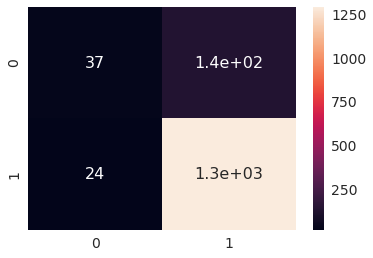

In [43]:
#finding train and test accuracy measurements -- BOW
getAccuracyReport(X_tr_vector_bow,X_test_vector_bow,y_tr, y_test,100,10)

# Important Features

In [44]:
#finding 20 important features --BOW
bow_rclf = applyGradientBoostingClassifierModel(X_tr_vector_bow,y_tr,100,10)
importances = bow_rclf.feature_importances_ 
feature_names =count_vect.get_feature_names() 
imp = sorted(zip(importances, feature_names),reverse=True)[:20] 
for imortance,feature in imp:    
    print(imortance,feature)

0.013800445169730067 horribl
0.011068093130995525 wors
0.010964959687082599 disappoint
0.010285563289256276 flavorless
0.010015661423180697 archer
0.009580461827034599 bad
0.008696002993438288 sourish
0.008692895460067098 spammer
0.00857574553048882 spaghetti
0.008574572460441531 aw
0.008571246151998677 liquer
0.008550393710759937 liptun
0.008540477534414738 whatchamacallit
0.008289277810406314 hfcs
0.008268510175954204 unaccept
0.008159797941318178 pbj
0.00806759716152297 peic
0.007928665319025969 typeo
0.007586541978766331 ravioli
0.007429093039071275 parmeson


# TFIDF Featurization

In [16]:
#Converting text to tfidf vector(tfidf)
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit(X_tr)
X_tr_vector_tfidf = final_tf_idf.transform(X_tr)
X_test_vector_tfidf = final_tf_idf.transform(X_test)

# Optimal numbers of estimator and max_depth

In [17]:
#getting optimal parameters -- tfidf
gridsearch_best_params_tfidf,gridsearch_best_score_tfidf = findGridSearchCVBestParameters(X_tr_vector_tfidf,y_tr)
print('Grid Search Best Params:\n',gridsearch_best_params_tfidf)
print('Grid Search Best Score:\n',gridsearch_best_score_tfidf)

Grid Search Best Params:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
Grid Search Best Score:
 0.8889795918367347


# Train and Test Accuracy using Optimal parameters

             precision    recall  f1-score   support

   negative       0.55      0.17      0.26       176
   positive       0.90      0.98      0.94      1324

avg / total       0.86      0.89      0.86      1500

Training accuracy: 0.9767346938775511
Test accuracy: 0.886


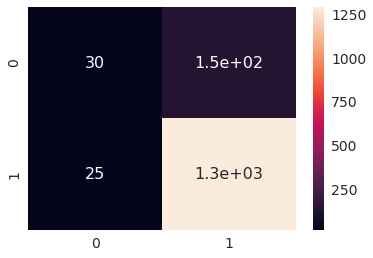

In [41]:
#finding train and test accuracy measurements -- tfidf
getAccuracyReport(X_tr_vector_tfidf,X_test_vector_tfidf,y_tr, y_test,60,10)

# Important Features

In [42]:
#finding 20 important features --tfidf
tfidf_rclf = applyGradientBoostingClassifierModel(X_tr_vector_tfidf,y_tr,60,10)
importances = tfidf_rclf.feature_importances_ 
feature_names =count_vect.get_feature_names() 
imp = sorted(zip(importances, feature_names),reverse=True)[:20] 
for imortance,feature in imp:    
    print(imortance,feature)

0.019055517430652456 horribl
0.015914791843975408 aw
0.01578902952395746 bad
0.015619801363409378 return
0.014759051705581443 box
0.013925444110643824 stuck
0.013770960064857658 disappoint
0.013439939233857407 worst
0.013396098692607637 order
0.013146299214473692 took
0.01287844115496534 wors
0.012687056363181544 disgust
0.012015956261276635 poor
0.011900704316059189 expens
0.01164471868333904 dollar
0.011642970398717721 archer
0.010607368361373182 perhap
0.010607169427964767 tast
0.010567088828966065 email
0.01049356104881973 elsewher


# AVGW2V Featurization

In [20]:
import gensim
import warnings
#supress warning
warnings.filterwarnings("ignore") 
i=0
list_of_sent_X_tr=[]
for sent in X_tr:
    filtered_sentence=[]
    sent = sent.decode('utf-8')
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_X_tr.append(filtered_sentence)

In [21]:
import gensim

#supress warnings
warnings.filterwarnings("ignore")

i=0
list_of_sent_X_test=[]
for sent in X_test:
    filtered_sentence=[]
    sent = sent.decode('utf-8')
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_X_test.append(filtered_sentence)

In [22]:
w2v_model=gensim.models.Word2Vec(list_of_sent_X_tr,min_count=1,size=50, workers=4) 

In [23]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_X_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_X_tr: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_X_tr.append(sent_vec)

In [24]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_X_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_X_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_X_test.append(sent_vec)

In [25]:
X_tr_vector_avgW2V = sent_vectors_X_tr
X_test_vector_avgW2V = sent_vectors_X_test 

In [26]:
from sklearn.preprocessing import Imputer
X_test_vector_avgW2V = Imputer().fit_transform(X_test_vector_avgW2V)

# Optimal numbers of estimator & max_depth

In [27]:
#getting optimal parameters -- avgW2V
gridsearch_best_params_avgW2v,gridsearch_best_score_avgW2V = findGridSearchCVBestParameters(X_tr_vector_avgW2V,y_tr)
print('Grid Search Best Params:\n',gridsearch_best_params_avgW2v)
print('Grid Search Best Score:\n',gridsearch_best_score_avgW2V)

Grid Search Best Params:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
Grid Search Best Score:
 0.8783673469387755


# Train and Test Accuracy using Optimal parameters

             precision    recall  f1-score   support

   negative       0.29      0.05      0.08       176
   positive       0.89      0.98      0.93      1324

avg / total       0.82      0.87      0.83      1500

Training accuracy: 1.0
Test accuracy: 0.8746666666666667


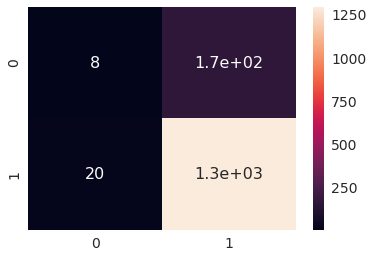

In [37]:
#finding train and test accuracy measurements -- avgW2V
getAccuracyReport(X_tr_vector_avgW2V,X_test_vector_avgW2V,y_tr, y_test,100,10)

# Important Features

In [38]:
#finding 20 important features --avgW2V
avgW2v_rclf = applyGradientBoostingClassifierModel(X_tr_vector_avgW2V,y_tr,100,10)
importances = avgW2v_rclf.feature_importances_ 
feature_names =count_vect.get_feature_names() 
imp = sorted(zip(importances, feature_names),reverse=True)[:20] 
for imortance,feature in imp:    
    print(imortance,feature)

0.06588382466036595 abysm
0.04729128136413907 absenc
0.0470623421453522 accur
0.04628681099150406 acerola
0.04490882865534225 acesuflamek
0.044110183692547336 abliti
0.043323331465821235 abund
0.040705072280876074 abil
0.036223867806625884 acknowledg
0.031347481399760804 accept
0.029787464878071098 absent
0.02862006878298456 accordion
0.027842104786126493 achiev
0.0261928022700215 abandon
0.026107007525913856 absorb
0.02293721349252433 abid
0.022422962202944718 abroad
0.020720199000761844 acclaim
0.020567747198048044 acid
0.019922756619767792 accent


# TFIDFW2Vec Featurization

In [30]:
tf_idf_X_tr_vect = TfidfVectorizer()
tf_idf_X_tr_vect.fit(X_tr)
final_tf_idf_X_tr_vect = tf_idf_X_tr_vect.transform(X_tr)
final_tf_idf_X_test_vect = tf_idf_X_tr_vect.transform(X_test)

In [31]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_X_tr_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_X_tr_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_X_tr: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try: 
            
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf_X_tr_vect[row, tfidf_feat.index(word)]
            sent_vec +=(vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_X_tr_vectors.append(sent_vec)
    row += 1

In [32]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_X_tr_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_X_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_X_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf_X_test_vect[row, tfidf_feat.index(word)]
            sent_vec +=(vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_X_test_vectors.append(sent_vec)
    row += 1

In [33]:
from sklearn.preprocessing import Imputer
X_tr_vector_tfidfW2V = tfidf_sent_X_tr_vectors
X_test_vector_tfidfW2V = tfidf_sent_X_test_vectors
X_tr_vector = Imputer().fit_transform(X_tr_vector_tfidfW2V)
X_test_vector = Imputer().fit_transform(X_test_vector_tfidfW2V)

# Optimal numbers of estimator and max_depth

In [34]:
#getting optimal parameters -- tfidfW2V
gridsearch_best_params_tfidfW2V,gridsearch_best_score_tfidfW2V = findGridSearchCVBestParameters(X_tr_vector_tfidfW2V,y_tr)
print('Grid Search Best Params:\n',gridsearch_best_params_tfidfW2V)
print('Grid Search Best Score:\n',gridsearch_best_score_tfidfW2V)

Grid Search Best Params:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
Grid Search Best Score:
 0.8787755102040816


# Train and Test Accuracy using Optimal parameters

             precision    recall  f1-score   support

   negative       0.32      0.04      0.07       176
   positive       0.89      0.99      0.93      1324

avg / total       0.82      0.88      0.83      1500

Training accuracy: 1.0
Test accuracy: 0.8773333333333333


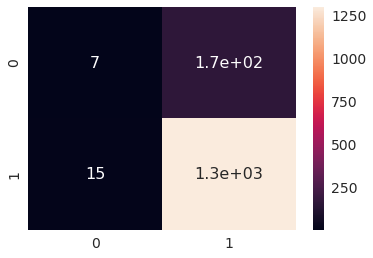

In [36]:
#finding train and test accuracy measurements -- tfidfW2V
getAccuracyReport(X_tr_vector_tfidfW2V,X_test_vector_tfidfW2V,y_tr, y_test,200,10)

# Important Features

In [40]:
#finding 20 important features --tfidfW2V
tfidfW2v_rclf = applyGradientBoostingClassifierModel(X_tr_vector_tfidfW2V,y_tr,200,10)
importances = tfidfW2v_rclf.feature_importances_
words = w2v_model.wv.index2word
imp = sorted(zip(importances, words),reverse=True)[:10]
for imortance,feature in imp:
    print(imortance,feature)

0.0692040918067005 even
0.061285537693417845 realli
0.051293216519857784 good
0.043909313717337764 mix
0.03940613565850673 cup
0.03716749012468737 coffe
0.03421537377507401 product
0.03353867989241923 drink
0.03324681901720305 hot
0.031764976506626255 also


# Conclusion

In [9]:
from prettytable import PrettyTable
t = PrettyTable()
t.field_names = ['Featurization', 'n_Estimator','max_depth','Train Error','Test Error']
t.add_row(["BOW","100","10","0.01061224489","0.10866666666"])
t.add_row(["TFIDF","60","10","0.02326530612","0.114"])
t.add_row(["AVGW2V","100","10","0","0.12533333333"])
t.add_row(["TFIDFW2V","200","10","0","0.12266666666"])
print(t)

+---------------+-------------+-----------+---------------+---------------+
| Featurization | n_Estimator | max_depth |  Train Error  |   Test Error  |
+---------------+-------------+-----------+---------------+---------------+
|      BOW      |     100     |     10    | 0.01061224489 | 0.10866666666 |
|     TFIDF     |      60     |     10    | 0.02326530612 |     0.114     |
|     AVGW2V    |     100     |     10    |       0       | 0.12533333333 |
|    TFIDFW2V   |     200     |     10    |       0       | 0.12266666666 |
+---------------+-------------+-----------+---------------+---------------+
